# 🏀 Análise de Desempenho dos Times Visitantes por Cidade

O objetivo desta análise é identificar quais cidades são **mais favoráveis para os times visitantes** na NBA. Avaliaremos onde os visitantes:

- Vencem mais partidas
- Marcam mais pontos
- Têm melhor desempenho geral
- Possuem histórico de vitórias consistente AAAAAAAAA acho que tem que reescrever isso pq é só os pontos em Minessota

Essa visão pode oferecer insights sobre vantagem de mando, impacto da torcida, ou até mesmo desempenho inconsistente dos times da casa.


In [1]:
# Importando bibliotecas válidas para a análise
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve

In [2]:
# Carregando csvs utilizados para  a análise
game = pd.read_csv('csv/game.csv')
team = pd.read_csv('csv/team.csv')

# Analizando quais colunas estão disponíveis para utilizarmos na análise
game.head(), team.head()


(   season_id  team_id_home team_abbreviation_home           team_name_home  \
 0      21946    1610610035                    HUS          Toronto Huskies   
 1      21946    1610610034                    BOM        St. Louis Bombers   
 2      21946    1610610032                    PRO  Providence Steamrollers   
 3      21946    1610610025                    CHS            Chicago Stags   
 4      21946    1610610028                    DEF          Detroit Falcons   
 
     game_id            game_date matchup_home wl_home  min  fgm_home  ...  \
 0  24600001  1946-11-01 00:00:00  HUS vs. NYK       L    0      25.0  ...   
 1  24600003  1946-11-02 00:00:00  BOM vs. PIT       W    0      20.0  ...   
 2  24600002  1946-11-02 00:00:00  PRO vs. BOS       W    0      21.0  ...   
 3  24600004  1946-11-02 00:00:00  CHS vs. NYK       W    0      21.0  ...   
 4  24600005  1946-11-02 00:00:00  DEF vs. WAS       L    0      10.0  ...   
 
    reb_away  ast_away  stl_away  blk_away  tov_away  

In [3]:
#filtramos apenas os jogos da temporada regular e playoffs

game = game[game['season_type'].isin(['Regular Season', 'Playoffs'])]
#agora vamos pegar um recorte dos ultimos 10 anos
game = game[game['game_date'] >= '2013-01-01']



In [4]:
# Use apenas colunas necessárias do DataFrame 'team'
teamHome = team[['id', 'city']].rename(columns={'id': 'team_id_home', 'city': 'city_home'})
teamAway = team[['id', 'city']].rename(columns={'id': 'team_id_away', 'city': 'city_away'})

# Merge com as cidades dos times da casa
game = game.merge(teamHome, on='team_id_home', how='left')

# Merge com as cidades dos times visitantes
game = game.merge(teamAway, on='team_id_away', how='left')


## Taxa de Vitórias dos Visitantes por Cidade

Nesta etapa, calculamos a **proporção de vitórias dos times visitantes** em cada cidade. 

Uma vitória do visitante ocorre quando o time da casa perde. Agrupamos os dados por `city_home` e contabilizamos:

- Número total de partidas na cidade
- Número de vitórias dos visitantes
- Taxa de vitória dos visitantes (vitórias / total de jogos)

Também filtramos para considerar **somente cidades com pelo menos 20 jogos**, para evitar distorções por amostras pequenas.


In [5]:
# Definindo a vitória de um visitante se o wl_home = L (Time da casa perdeu)
game['visitor_win'] = game['wl_home'] == 'L'

# Agrupando por cidade do time da casa e calculando o total de jogos em que o time visitante ganha
visitorsWinByCity = game.groupby('team_abbreviation_home').agg(
    visitor_wins=('visitor_win', 'sum'),           # Quantidade total de vitórias visitantes
    games_played=('visitor_win', 'count')          # Quantidade total de jogos jogados naquela cidade
).reset_index()

# Calculando taxa de vitória de vitória de visitantes
visitorsWinByCity['winRate'] = (
    visitorsWinByCity['visitor_wins'] / visitorsWinByCity['games_played']
)

# Filtrando cidades com muito poucos jogos (Menos que vinte)
visitorsWinByCity = visitorsWinByCity[visitorsWinByCity['games_played'] >= 20]

visitorsWinByCity = visitorsWinByCity.sort_values('winRate', ascending=False)
visitorsWinByCity.head(10)

,team_abbreviation_home,visitor_wins,games_played,winRate
21,ORL,229,403,0.568238
19,NYK,232,411,0.564477
25,SAC,222,403,0.550868
8,DET,219,401,0.546135
13,LAL,221,424,0.521226
17,MIN,209,403,0.518610
1,BKN,211,427,0.494145
4,CHI,203,417,0.486811
23,PHX,207,427,0.484778
3,CHA,193,400,0.482500


## Cidades Onde os Visitantes Mais Vencem

O gráfico a seguir mostra as **10 cidades com maior taxa de vitórias para visitantes**. Quanto maior a barra, maior a proporção de vezes que os visitantes ganharam naquela cidade.

Essa visualização ajuda a identificar os locais onde a vantagem de mando é mais fraca.


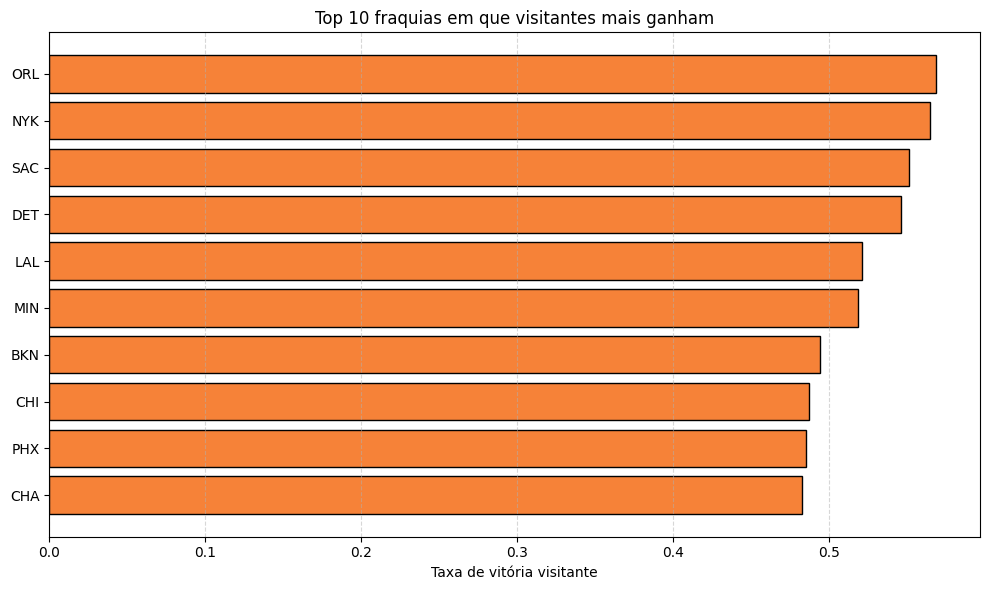

In [6]:
# Plotando um gráfico de barras para que seja possível analisar quais as 10 cidades em que visitantes mais ganham
topWinCities = visitorsWinByCity.sort_values('winRate', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(topWinCities['team_abbreviation_home'], topWinCities['winRate'], color='#f68238', edgecolor='black')
plt.xlabel('Taxa de vitória visitante')
plt.title('Top 10 fraquias em que visitantes mais ganham')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



## Cidades Onde Visitantes Marcam Mais Pontos

Além das vitórias, também analisamos **a média de pontos marcados por visitantes em cada cidade**.

Essa métrica complementa a taxa de vitória, indicando onde os visitantes têm melhor desempenho ofensivo — mesmo que nem sempre vençam.


In [7]:
# Calculando quantos pontos os visitantes fazem por cidade
visitorPoints = game.groupby('team_abbreviation_home').agg(
    avg_pts_away=('pts_away', 'mean'), # Calculando a média de pontos visitantes
    std_pts_away=('pts_away', 'std'),  # Calculando desvio padrão
    num_games=('pts_away', 'count')    # Calculando quantidade de jogos
).reset_index()

visitorPoints.sort_values('avg_pts_away', ascending=False).head()


,team_abbreviation_home,avg_pts_away,std_pts_away,num_games
25,SAC,110.550868,12.618760,403
18,NOP,108.826406,12.855406,409
17,MIN,108.588089,13.073046,403
23,PHX,108.566745,11.526134,427
10,HOU,108.155056,12.932630,445


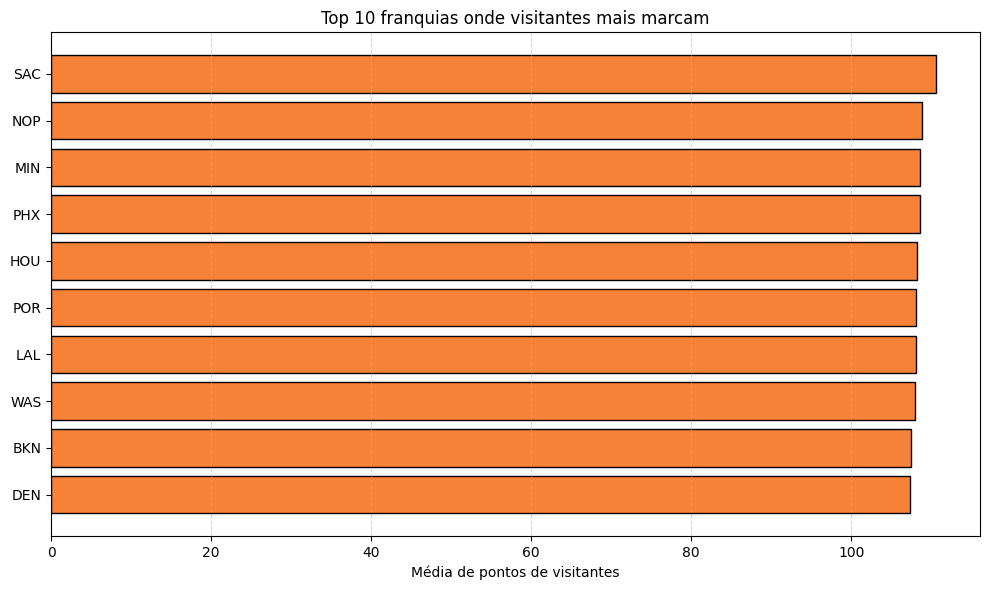

In [8]:
# Plotando gráfico de barras que facilita a vizualição de quantos pontos os visitantes marcam nos top 10 cidades
topPtsCities = visitorPoints.sort_values('avg_pts_away', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(topPtsCities['team_abbreviation_home'], topPtsCities['avg_pts_away'], color='#f68238', edgecolor='black')
plt.xlabel('Média de pontos de visitantes')
plt.title('Top 10 franquias onde visitantes mais marcam')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
ranked_3_list = game.groupby('team_abbreviation_home')['fg3_pct_away'].mean().sort_values(ascending=False)
print(ranked_3_list)

team_abbreviation_home
POR    0.366441
MIN    0.365050
SAC    0.363712
ORL    0.362749
TOR    0.362383
CLE    0.359561
PHX    0.359473
SAS    0.358421
UTA    0.356102
MIL    0.355354
NOP    0.355291
MEM    0.354441
BKN    0.354333
OKC    0.353339
WAS    0.352857
DET    0.351182
DAL    0.350593
NYK    0.350066
MIA    0.349144
CHI    0.348218
CHA    0.348085
ATL    0.347975
PHI    0.347679
IND    0.347209
DEN    0.346929
LAL    0.343785
HOU    0.343618
LAC    0.342630
BOS    0.340204
GSW    0.338233
Name: fg3_pct_away, dtype: float64


C:\Users\alkmi\AppData\Local\Temp\ipykernel_29084\2590069977.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranked_3_list.index, y=ranked_3_list.values, palette='viridis')


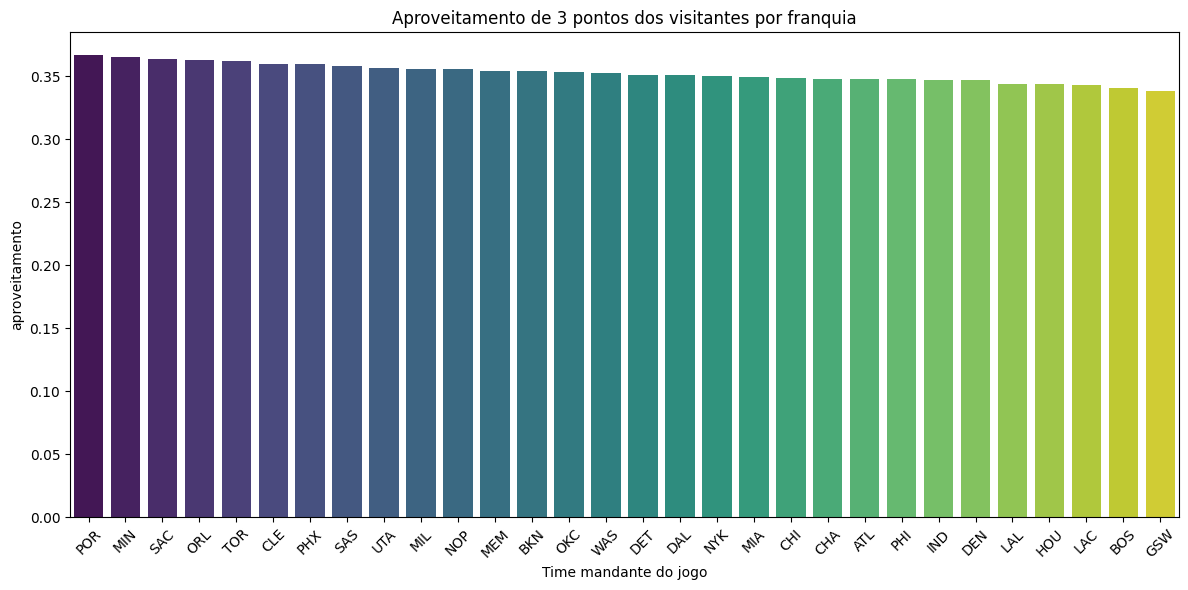

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(x=ranked_3_list.index, y=ranked_3_list.values, palette='viridis')
plt.xlabel('Time mandante do jogo')
plt.ylabel('aproveitamento')
plt.title('Aproveitamento de 3 pontos dos visitantes por franquia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
#agora vamos ver o aproveitamento em arremessos em cada cidade
ranked_fg_list = game.groupby('team_abbreviation_home')['fg_pct_away'].mean().sort_values(ascending=False)
print(ranked_fg_list)

team_abbreviation_home
SAC    0.469670
MIN    0.466459
NOP    0.464188
DET    0.463741
ORL    0.461663
DEN    0.461617
DAL    0.461364
PHX    0.460602
WAS    0.460121
CLE    0.459833
LAL    0.458021
CHI    0.457712
POR    0.457212
HOU    0.456861
ATL    0.456298
BKN    0.456255
SAS    0.455269
NYK    0.453835
CHA    0.453703
MIA    0.453496
PHI    0.453360
OKC    0.451422
TOR    0.450332
BOS    0.448358
IND    0.448271
LAC    0.447540
MIL    0.447124
UTA    0.445657
MEM    0.444806
GSW    0.439262
Name: fg_pct_away, dtype: float64


C:\Users\alkmi\AppData\Local\Temp\ipykernel_29084\3552265516.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranked_fg_list.index, y=ranked_fg_list.values, palette='viridis')


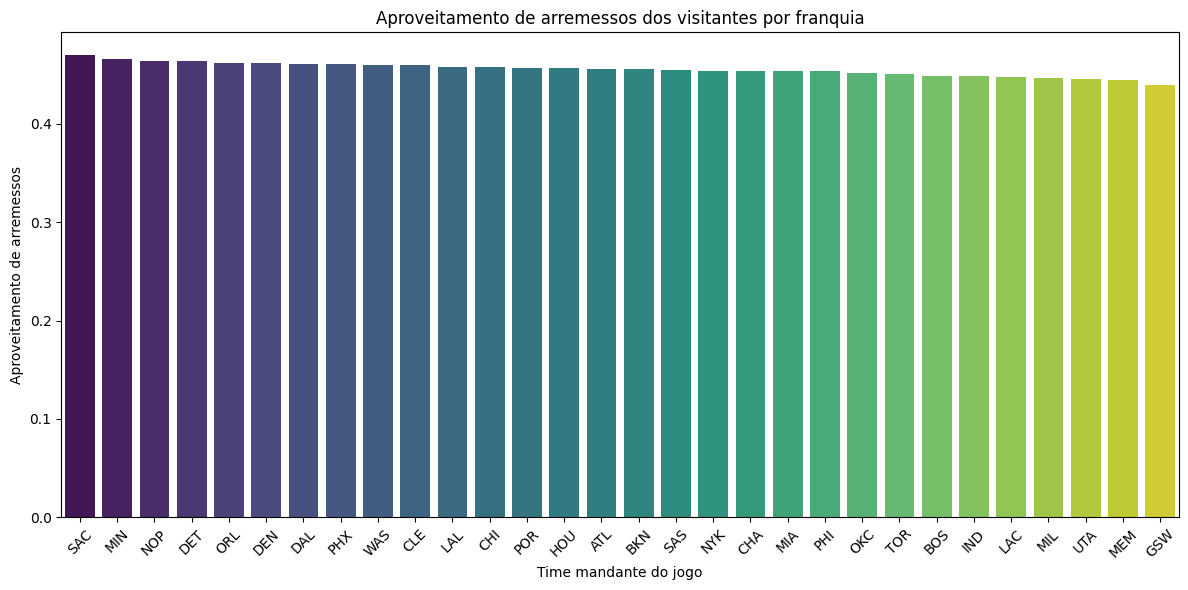

In [20]:
#plotar um gráfico de barras para visualizar a média de aproveitamento de arremessos dos visitantes por cidade
plt.figure(figsize=(12, 6))
sns.barplot(x=ranked_fg_list.index, y=ranked_fg_list.values, palette='viridis')
plt.xlabel('Time mandante do jogo')
plt.ylabel('Aproveitamento de arremessos')
plt.title('Aproveitamento de arremessos dos visitantes por franquia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Score Composto de Favorabilidade para Visitantes

Combinamos múltiplos indicadores para gerar um **score composto** de "cidades favoráveis para visitantes", levando em conta:

- Taxa de vitórias dos visitantes
- Média de pontos marcados
- Plus/minus médio dos visitantes

Esse índice balanceado permite classificar as cidades de forma mais robusta, considerando não apenas vitórias mas também qualidade do desempenho.


In [13]:
# Acrescentando algumas estatísticas de visitantes para agregar no compilado final
visitorsStats = game.groupby('team_abbreviation_home').agg(
    avg_ast_away=('ast_away', 'mean'),
    avg_reb_away=('reb_away', 'mean'),
    avg_stl_away=('stl_away', 'mean'),
    avg_blk_away=('blk_away', 'mean'),
    avg_plus_minus=('plus_minus_away', 'mean')
).reset_index()

visitorsStats.head()


,team_abbreviation_home,avg_ast_away,avg_reb_away,avg_stl_away,avg_blk_away,avg_plus_minus
0,ATL,24.284065,44.170901,8.120092,4.974596,-1.916859
1,BKN,22.274005,44.601874,8.088993,4.646370,0.133489
2,BOS,22.083691,43.409871,7.386266,4.766094,-4.454936
3,CHA,23.972500,44.262500,6.940000,5.405000,-0.607500
4,CHI,23.585132,43.721823,7.390887,5.484412,0.158273


In [14]:
# Agrupando todas as métricas
favCitiesStats = visitorsWinByCity.merge(visitorPoints, on='team_abbreviation_home')
favCitiesStats = favCitiesStats.merge(visitorsStats, on='team_abbreviation_home')

# Cálculo do "Composite Score" (pontuação composta) — os valores foram definidos pelo grupo! 
favCitiesStats['composite_score'] = (
    favCitiesStats['winRate'] * 0.4 +  # 40% do peso vem da taxa de vitórias dos visitantes na cidade

    # 30% do peso vem da média de pontos dos visitantes, normalizada pela maior média registrada
    favCitiesStats['avg_pts_away'] / favCitiesStats['avg_pts_away'].max() * 0.3 +

    # 30% do peso vem do plus-minus médio dos visitantes, também normalizado
    favCitiesStats['avg_plus_minus'] / favCitiesStats['avg_plus_minus'].max() * 0.3
)

favCitiesStats.sort_values('composite_score', ascending=False).head(10)


,team_abbreviation_home,visitor_wins,games_played,winRate,avg_pts_away,std_pts_away,num_games,avg_ast_away,avg_reb_away,avg_stl_away,avg_blk_away,avg_plus_minus,composite_score
0,ORL,229,403,0.568238,107.094293,12.833842,403,23.513648,44.280397,7.669975,4.957816,2.694789,0.817915
2,SAC,222,403,0.550868,110.550868,12.618760,403,23.995037,43.235732,7.905707,4.665012,1.518610,0.689408
1,NYK,232,411,0.564477,105.554745,12.896352,411,22.238443,42.990268,7.335766,4.379562,1.296837,0.656604
3,DET,219,401,0.546135,105.965087,11.987443,401,23.852868,43.553616,7.286783,4.847880,0.443890,0.555426
4,LAL,221,424,0.521226,108.068396,12.119677,424,24.662736,44.625000,8.058962,4.686321,0.108491,0.513832
6,BKN,211,427,0.494145,107.395785,12.547386,427,22.274005,44.601874,8.088993,4.646370,0.133489,0.503957
7,CHI,203,417,0.486811,104.666667,14.080014,417,23.585132,43.721823,7.390887,5.484412,0.158273,0.496376
5,MIN,209,403,0.518610,108.588089,13.073046,403,23.337469,43.754342,7.560794,4.895782,-0.312655,0.467311
9,CHA,193,400,0.482500,105.427500,12.954509,400,23.972500,44.262500,6.940000,5.405000,-0.607500,0.411466
8,PHX,207,427,0.484778,108.566745,11.526134,427,21.810304,43.416862,8.000000,4.449649,-1.096019,0.366511


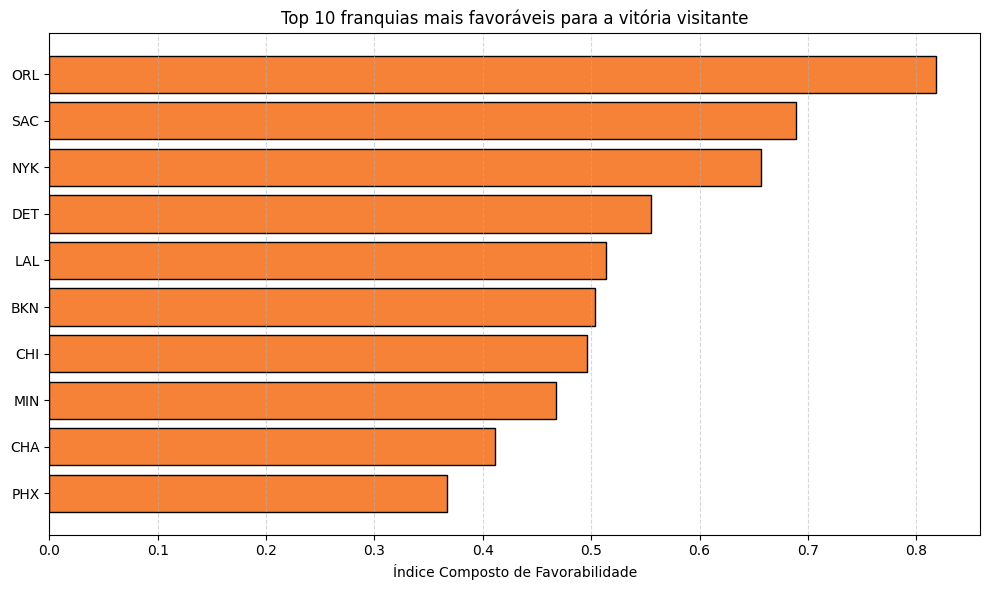

In [15]:
# Plotando quais as 10 cidades mais favoráveis para os visitantes conforme as variáveis observadas pelo grupo
topCompositieCities = favCitiesStats.sort_values('composite_score', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(topCompositieCities['team_abbreviation_home'], topCompositieCities['composite_score'], color='#f68238', edgecolor='black')
plt.xlabel('Índice Composto de Favorabilidade')
plt.title('Top 10 franquias mais favoráveis para a vitória visitante')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Análise Estatística: Pontuação dos Visitantes por Cidade (ANOVA)
Nesta etapa, realizamos uma análise de variância para investigar se times visitantes pontuam de forma significativamente diferente dependendo da cidade onde jogam.

Interpretando o p-valor:

Se p < 0.05, há diferença estatisticamente significativa entre as cidades — ou seja, os visitantes pontuam de forma diferente dependendo de onde jogam.

Se p ≥ 0.05, as diferenças observadas podem ser atribuídas ao acaso.

In [16]:
from scipy.stats import f_oneway

# Converter datas e filtrar últimas 10 temporadas
game['game_date'] = pd.to_datetime(game['game_date'])
last_10 = game[game['game_date'] >= '2013-07-01']

# Remover entradas sem cidade ou pontos de visitante
last_10_clean = last_10.dropna(subset=['team_abbreviation_home', 'pts_away'])

# Agrupar os pontos dos visitantes por cidade
visitor_points_by_city = last_10_clean.groupby('team_abbreviation_home')['pts_away'].apply(list)

# Realizar teste F
f_stat, p_val = f_oneway(*visitor_points_by_city)

# Resultados
print("Pontos dos Visitantes por Cidade")
print("F-value:", f_stat)
print("p-value:", p_val)

# Interpretação
if p_val < 0.05:
    print("Resultado: Há diferença estatisticamente significativa entre as cidades.")
else:
    print("Resultado: Não há diferença estatisticamente significativa entre as cidades.")


Pontos dos Visitantes por Cidade
F-value: 10.105424969103792
p-value: 7.474850220480021e-45
Resultado: Há diferença estatisticamente significativa entre as cidades.


## Distribuição de Pontos dos Visitantes na Cidade Mais Favorável

Este histograma mostra a **distribuição de pontos marcados pelos times visitantes na cidade onde eles mais vencem**.

É uma análise mais granular, que revela se os visitantes consistentemente pontuam alto ou se há muita variação nos resultados.


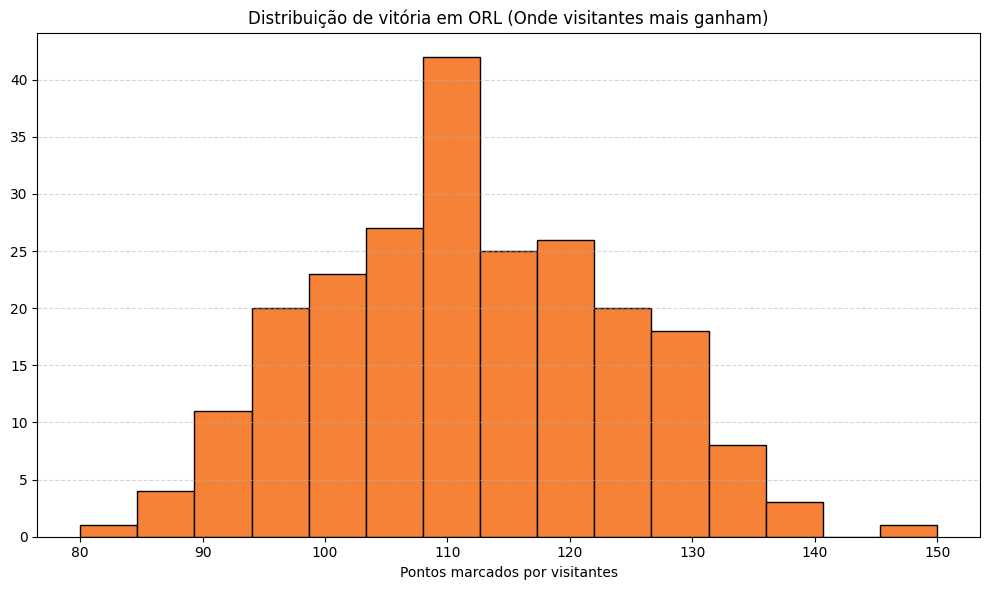

In [17]:
# Selecionamos a cidade onde os visitantes mais ganham
topCity = visitorsWinByCity.iloc[0]['team_abbreviation_home']

# Selecionamos apenas jogos com vitórias de visitantes
visitorsWinsInTopCities = game[(game['team_abbreviation_home'] == topCity) & (game['visitor_win'])]

plt.figure(figsize=(10, 6))
plt.hist(visitorsWinsInTopCities['pts_away'], bins=15, color='#f68238', edgecolor='black')
plt.xlabel('Pontos marcados por visitantes')
plt.title(f'Distribuição de vitória em {topCity} (Onde visitantes mais ganham)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
